In [1]:
import xarray as xr
import glob
import netCDF4 as nc
import numpy as np
import socket
import json
import os
import sys
from datetime import datetime, timezone, timedelta
import xmitgcm as xm

import matplotlib.pyplot as plt

# Get the path to the parent folder (one level up)
parent_folder = os.path.abspath(os.path.join(os.getcwd(), '../..'))
print(parent_folder)

# Add the parent folder to sys.path
sys.path.append(parent_folder)
from mitgcm.utils_mitgcm import open_mitgcm_ds_from_config
#%matplotlib notebook
# seaborn for interactive plots or bokee or hvplot

/home/rasmusso@eawag.wroot.emp-eaw.ch/Documents/plot_results


In [2]:
model = 'test_zurich'
lake_name='Zurich'
mitgcm_config, ds_to_plot = open_mitgcm_ds_from_config('..//config.json', model)

In [3]:
ds_to_plot = ds_to_plot.isel(YG=range(0,54), YC=range(0,54))

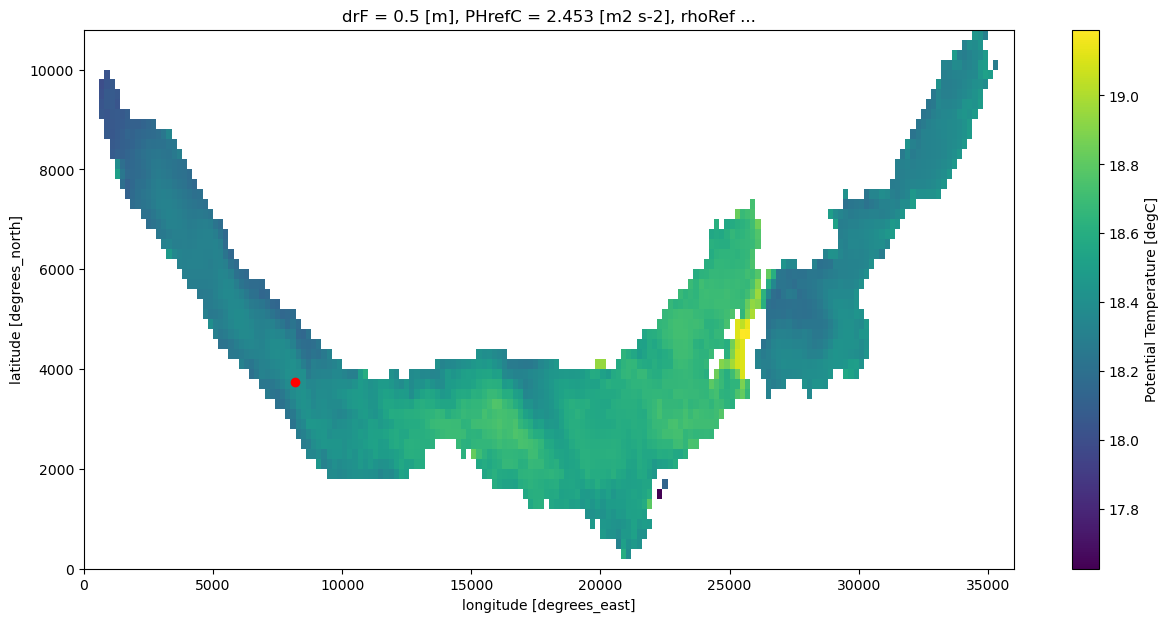

In [4]:
xc_mitgcm_station = 8178
yc_mitgcm_station = 3739

date_plot_profil = datetime(2024,3,6,0,0,0)
date_plot_profil_str = date_plot_profil.strftime('%Y%m%d%H%M')

#chose between ['UVEL', 'VVEL', 'WVEL', 'THETA', 'rA', ..., 'XG', 'YG', 'Zp1', 'Zu', 'Zl']
plt.close('all')
plt.figure(figsize=(15,7))
ds_sel = ds_to_plot['THETA'].isel(Z=0, time=-100)
ds_sel.where(ds_sel != 0, np.nan).plot()
plt.scatter(xc_mitgcm_station,yc_mitgcm_station,color='red')
plt.show()

In [60]:
#select the meteo input you wish to plot
var='u10'
#select the corresponding result name
var2 = 'UVEL'

bin_file_path = rf"/storage/alplakes_test/Soren/lake_zh/march_24/binary_data/{var}.bin"
with open(bin_file_path, 'rb') as fid:
    binary_data = np.fromfile(fid, dtype='>f8')
grid_resolution = 200
grid_fact = grid_resolution / 50
nx =180
ny = 60
nt = len(binary_data) / nx /ny

from datetime import datetime, timedelta

start_date = datetime(2024, 3, 6)

date_list = []
for i in range(0, int(nt)):
    current_date = start_date + timedelta(hours=i)
    date_list.append(current_date)

bin_array = np.reshape(binary_data, (int(nt),int(ny),int(nx)))
i_time = -1


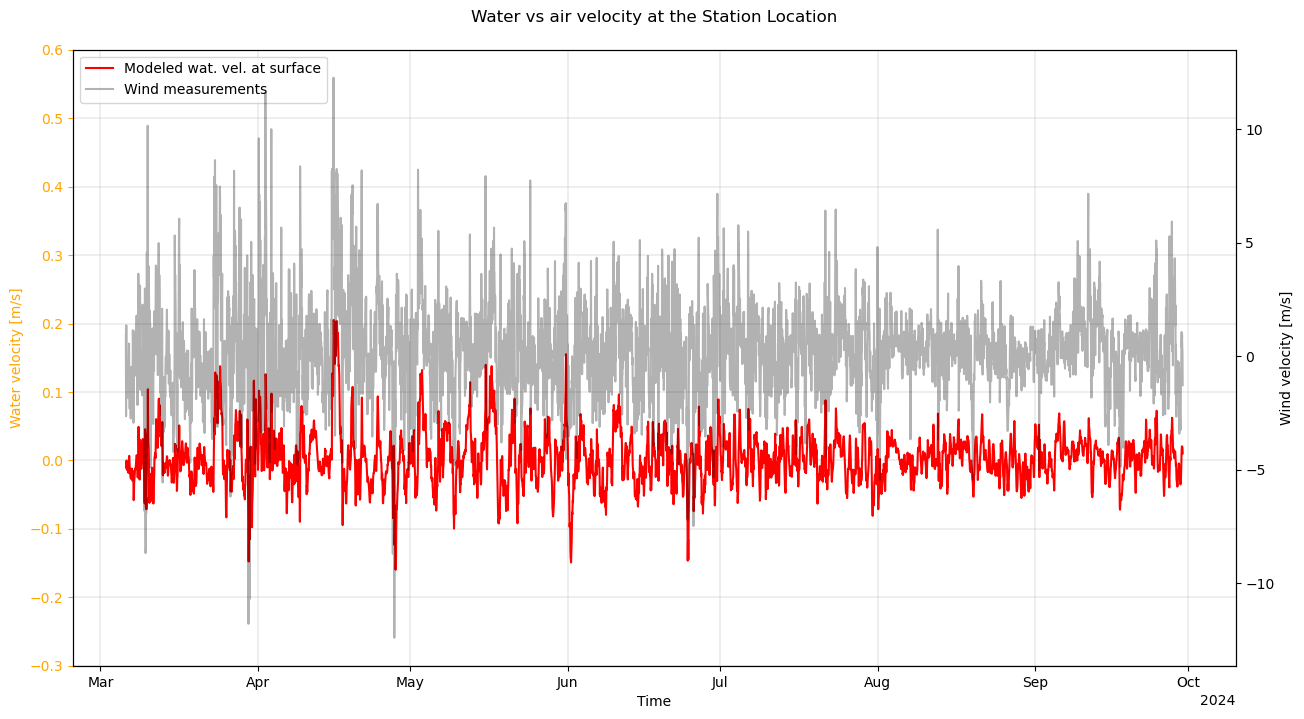

In [61]:
# FIGURE AIR VS WATER VELOCITY

plt.close('all')
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot water velocity on primary y-axis
ds_to_plot[var2].sel(XG=xc_mitgcm_station, YC=yc_mitgcm_station, Z=0, method='nearest').plot(
ax=ax1, color = "orange",label="Modeled wat. vel. at surface")

ax1.set_ylabel('Water velocity [m/s]', color='orange')
ax1.set_title("")
ax1.set_ylim(-0.3, 0.6)
ax1.tick_params(axis='y', colors='orange')
ax1.grid(True, which='both', linewidth=0.3)

# Create secondary y-axis for wind speed
ax2 = ax1.twinx()
ax2.plot(date_list, bin_array[:, 19, 41], linestyle='-', color='black',alpha=0.3, label='Wind measurements')

ax2.set_ylabel('Wind velocity [m/s]', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Water vs air velocity at the Station Location',pad=20)
#plt.savefig(rf"{lake_name}_Vel_air_vs_wat_march.png")
plt.show()

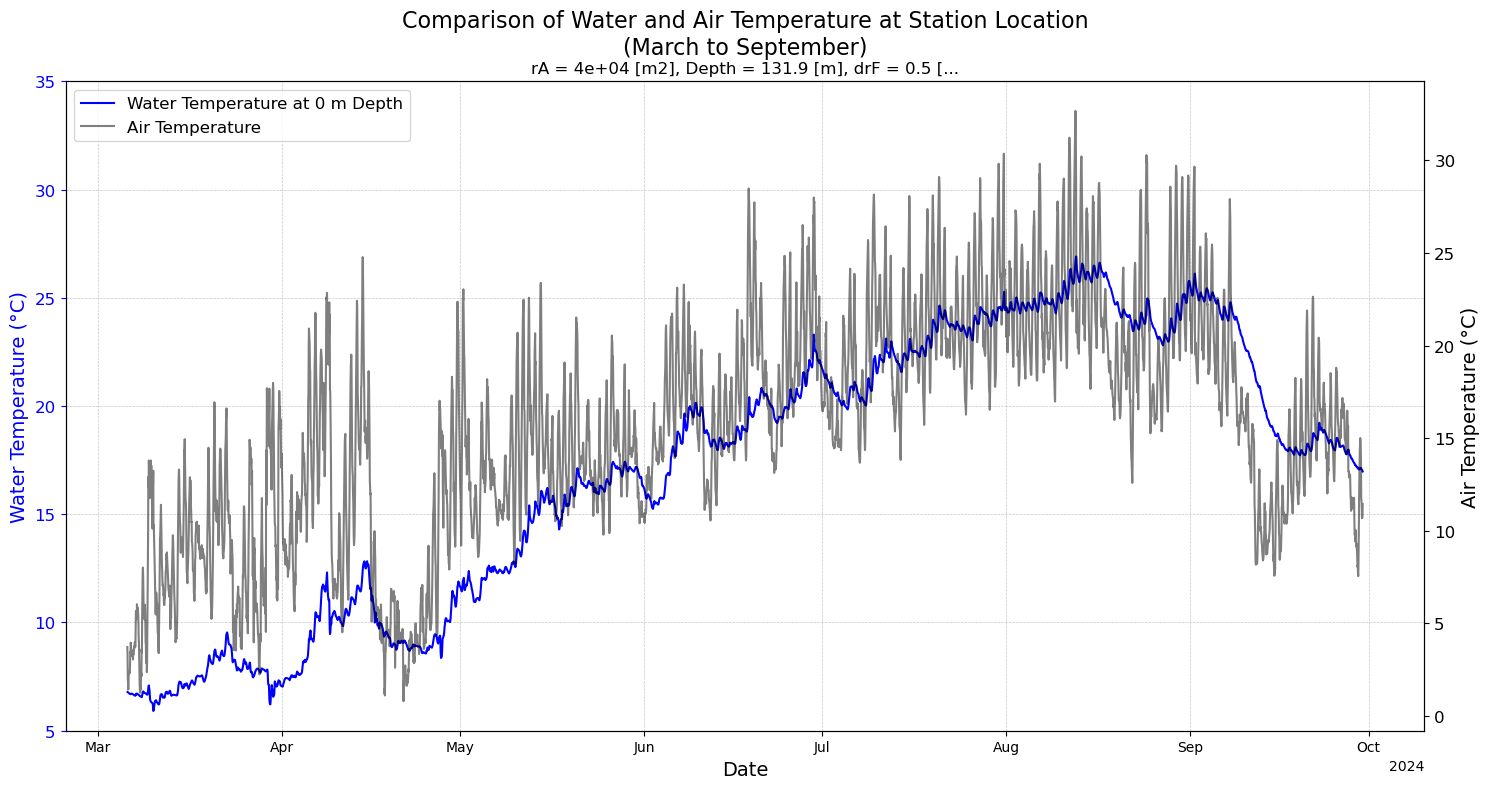

In [58]:
import matplotlib.dates as mdates
import pandas as pd


plt.close('all')
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot water temperature on primary y-axis
for i in range(1):
    ds_to_plot[var2].sel(XC=xc_mitgcm_station, YC=yc_mitgcm_station, Z=-i*5, method='nearest').plot(
        ax=ax1, color="blue", label=f"Water Temperature at {i*5} m Depth")

# Primary y-axis (Water Temperature)
ax1.set_ylabel('Water Temperature (°C)', fontsize=14, color='blue')
ax1.tick_params(axis='y', colors='blue', labelsize=12)
ax1.set_ylim(5, 35)
ax1.grid(True, which='both', linewidth=0.5, linestyle='--', alpha=0.7)

# Secondary y-axis (Air Temperature)
ax2 = ax1.twinx()
ax2.plot(date_list, bin_array[:, 19, 41] - 273.15, linestyle='-', color='black', alpha=0.5, label='Air Temperature')

ax2.set_ylabel('Air Temperature (°C)', fontsize=14, color='black')
ax2.tick_params(axis='y', labelcolor='black', labelsize=12)

# X-axis formatting (Optional: use if x-axis is datetime)
ax1.set_xlabel('Date', fontsize=14)
if isinstance(date_list[0], (np.datetime64, pd.Timestamp)):
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    fig.autofmt_xdate()

# Combine and place legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

# Title
plt.title('Comparison of Water and Air Temperature at Station Location\n(March to September)', fontsize=16, pad=20)

# Save (optional)
# plt.savefig(f"{lake_name}_Temp_air_vs_water_Mar_Sept.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


In [5]:
def plot_map(i_time: int, i_depth: int):
    plt.ioff()
    plt.close()
    fig, ax = plt.subplots(figsize=(15,5))
    
    T_plot = ds_to_plot['time'].values[i_time]
    Z_plot = ds_to_plot['Z'].values[i_depth]
    xr_plot = ds_to_plot['THETA'].sel(time=T_plot, Z=Z_plot)
    xr_plot = xr_plot.where(xr_plot != 0, np.nan)
    xr_plot.plot(cmap='jet', vmin=5, vmax=25)
    plt.axis('equal')
    
    subsetting_factor = 3
    X_trimmed = ds_to_plot['XC'][::subsetting_factor]
    Y_trimmed = ds_to_plot['YC'][::subsetting_factor]
    U_trimmed = ds_to_plot['UVEL'].sel(time=T_plot, Z=Z_plot)[:,1:][::subsetting_factor,::subsetting_factor]
    V_trimmed = ds_to_plot['VVEL'].sel(time=T_plot, Z=Z_plot)[1:,:][::subsetting_factor,::subsetting_factor]
    
    U_trimmed = U_trimmed.where(U_trimmed != 0, np.nan)
    V_trimmed = V_trimmed.where(V_trimmed != 0, np.nan)
    plt.quiver(X_trimmed, Y_trimmed, U_trimmed, V_trimmed, scale=7)
    
    #plt.xlim(37500,42500)
    #plt.ylim(19500,24500)
    
    plt.text(0.02, 0.98, f'{np.datetime_as_string(T_plot, unit="s").replace("T", " ")}', transform=plt.gca().transAxes, ha='left', va='top')
    plt.text(0.02, 0.9, f'Z={Z_plot}m', transform=plt.gca().transAxes, ha='left', va='top')
    plt.title('')
    
    # Remove axis, ticks, labels, and title
    #ax.set_xticks([])
    #ax.set_yticks([])
    #ax.set_xlabel("")
    #ax.set_ylabel("")
    #ax.set_title("")
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    
    return plt.gcf()

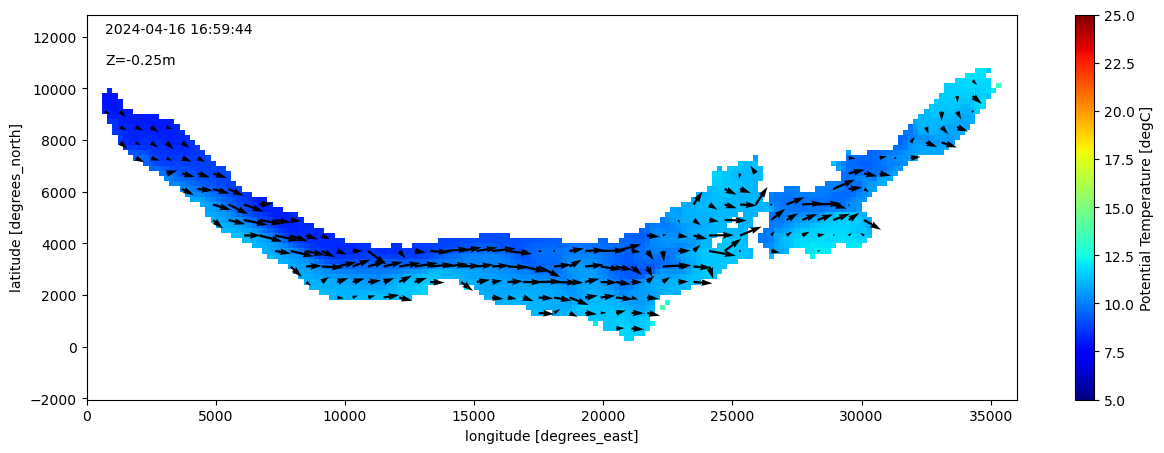

In [6]:
i_time = 1000
i_depth = 0
plot_map(i_time, i_depth)

In [23]:
sta_name = 'lower_zurich'
with open(os.path.join('/home/rasmusso@eawag.wroot.emp-eaw.ch/Documents/plot_results/config_points.json'), 'r') as file:
    config_points = json.load(file)[sta_name]
    
xc_mitgcm_station = config_points['xc_mitgcm_200m']
yc_mitgcm_station = config_points['yc_mitgcm_200m']

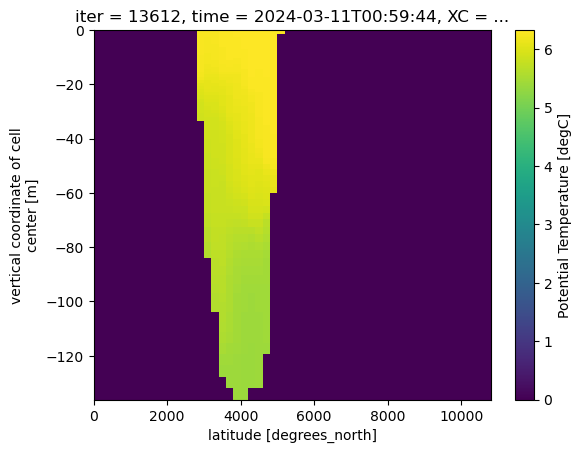

In [26]:
ds_to_plot['THETA'].isel(time=i_time).sel(XC=xc_mitgcm_station, method='nearest').plot()
plt.show()

# Create video

In [2]:
make_video = True
output_video_folder = r'/home/rasmusso@eawag.wroot.emp-eaw.ch/Documents/plot_results/output_plots/videos'

import os

# Ensure the output directory exists
os.makedirs(output_video_folder, exist_ok=True)

if make_video != True:
    exit

for i in range(len(ds_to_plot['time'].values)):
    fig = plot_map(i,0)
    filepath = os.path.join(output_video_folder, f'temperature_{i}.png')
    print(f"saving: {filepath}")
    fig.savefig(filepath)
    plt.close()

In [3]:
if make_video != True:
    exit
    
from moviepy.editor import ImageSequenceClip
import glob
import os

video_name = 'ZH_current_video.mp4'
fps = 10

# Get all images
images = glob.glob(f"{output_video_folder}/*.png")

# Create a clip from the images
clip = ImageSequenceClip(images, fps=fps)
clip.write_videofile(os.path.join(output_video_folder, video_name), fps=fps, codec="libx264", audio=False)
print("Video created successfully.")

ModuleNotFoundError: No module named 'moviepy.editor'